## Investigating the use of the [galaxy zoo challenge](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/overview) Image dataset for an image classification task.

### Importing needed packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from kneed import KneeLocator
from sklearn.cluster import KMeans
sns.set()

import warnings
warnings.filterwarnings('ignore')

I'm working from the directory housing the csv file that holds the galaxy ids as well as the 37 morphologies alongside the proability distribution.

In [3]:
data = pd.read_csv('training_solutions_rev1.csv')

In [4]:
pd.set_option("display.max_columns",1000)

In [5]:
data.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027227,0.000000,0.027227,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


Visualizing how the probabilities in the first 9 rows are distributed over their given indices (which obviously corresponds to the columns): 

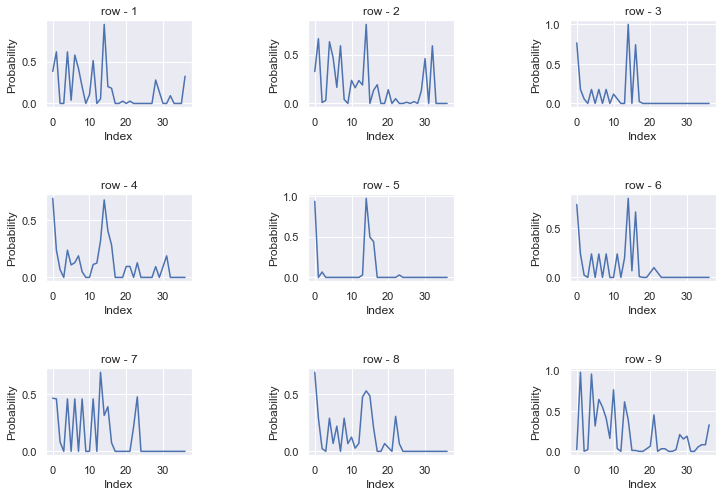

In [6]:
plt.figure(figsize=(12,8))

for i in range(9):
    ax=plt.subplot(3,3,i+1)
    ax.set_title(f'row - {i+1}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Probability')
    ax.plot(data.iloc[i,1:].values)
    
    plt.subplots_adjust(wspace=0.8, hspace= 1) #to adjust the spacing between the subplots

We can observe Certain features were notable over others ,as shown below:

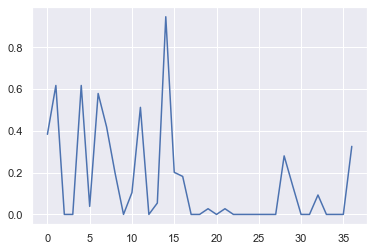

In [7]:
plt.plot(data.iloc[0,1:].values);

while some galaxies had more than one prominent feature as shown below:

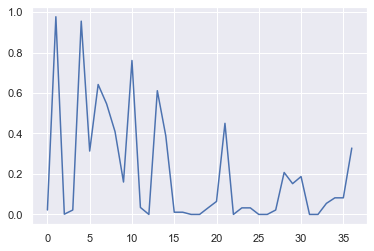

In [8]:
plt.plot(data.iloc[8,1:].values);

Therefore assigning the feature with the most predicted value by the participants as the defining feature of that galaxy might be quite inaccurate, so let's see how many galaxies had closely valued prominent features.
(I'm making the assumption that most galaxies in this dataset would have at most 2 closely valued prominent feature)

In [9]:
data.columns

Index(['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'],
      dtype='object')

lets create a **copy** of the original dataset so we won't lose the **GalaxyID** column during analysis

In [10]:
file = data.copy()

In [11]:
file.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027227,0.000000,0.027227,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


dropping the **GalaxyID** column so we can concentrate on the 37 categories of features

In [12]:
file.drop('GalaxyID' , axis=1, inplace=True)

In [13]:
no_of_galaxies_with_more_than_one_prominent_feature = 0
for i in range(len(file)):
    if file.iloc[i,:].sort_values(ascending=False)[0] - file.iloc[i,:].sort_values(ascending=False)[1] <= 0.1:
        no_of_galaxies_with_more_than_one_prominent_feature += 1

In [14]:
no_of_galaxies_with_more_than_one_prominent_feature

29064

In [15]:
no_of_galaxies_with_more_than_one_prominent_feature/len(file)

0.4719867485140797

from above it can be seen we have about over 47% of galaxies having more than one prominent feature as decided by the participants. I tried laying my hands on the explanation of the 37 categories used in this dataset but all efforts proved abortive, for instance: 

                        "Class7.1": "completely_round"
                        
                        "Class7.2": "in_between",
                        
                        "Class7.3": "cigar_shaped",
                        
                        "Class2.1": "on_edge",
                        
                        "Class4.1": "has_signs_of_spiral",
                        
                        "Class3.1": "spiral_barred",
                        
                        "Class3.2": "spiral"
                        
The above was gotten from the competition's discussion [section](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/discussion)

(Given that the full description of the classes weren't available , I couldn't investigate the cases with more than one prominent features and ascertain whether they were closely related or not).

In light of the above limitations I decided to just stick to using the feature with the most probability value to define the given galaxy:

In [16]:
categorical_max = []    #This list would host the names of the morphology or feature with the highest value 
                        #for each row (galaxy) 

This code get's the index of the maximum value of each row grabs it's column name and then append it to *categorical_max*:

In [17]:
for i in range(len(file)):
    categorical_max.append(file.columns[list(file.iloc[i].values).index(max(list(file.iloc[i].values)))])

In [18]:
len(categorical_max)==len(file)

True

converting **categorical_max** to Series object for easier analysis

In [19]:
categorical_max = pd.Series(categorical_max)

In [20]:
categorical_max.rename('categorical_max', inplace=True)

0        Class6.2
1        Class6.2
2        Class6.2
3        Class1.1
4        Class6.2
           ...   
61573    Class6.2
61574    Class1.1
61575    Class6.1
61576    Class1.2
61577    Class1.1
Name: categorical_max, Length: 61578, dtype: object

<AxesSubplot:xlabel='categorical_max', ylabel='count'>

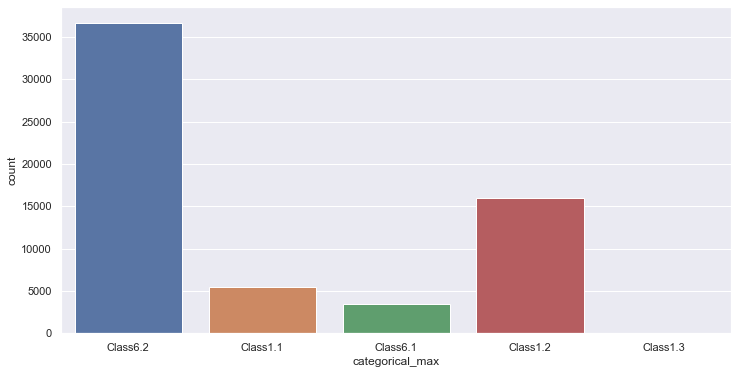

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(categorical_max)

In [22]:
categorical_max.value_counts()/len(categorical_max)*100

Class6.2    59.608951
Class1.2    25.885868
Class1.1     8.848940
Class6.1     5.635129
Class1.3     0.021111
Name: categorical_max, dtype: float64

From above it can be seen that we have 5 major distinct Morphology/Feature with Class6.2 occupying close to 60% of our data and class 1.3 occupying roughly 2% of the entire dataset

### Let's try to see what these classes looks like:

locating the path to which the image data is located

In [23]:
train_image_path = "../images_training_rev1//images_training_rev1"

In [24]:
from matplotlib.image import imread

Let's view what the first image in the folder looks like:

In [25]:
train_image_1 = train_image_path+'/100008.jpg'

**sns.set()** was casting gridlines over the image below , so i had to get rid of it's effect using the lines of codes below:

In [26]:
import matplotlib

In [27]:
matplotlib.rc_file_defaults()

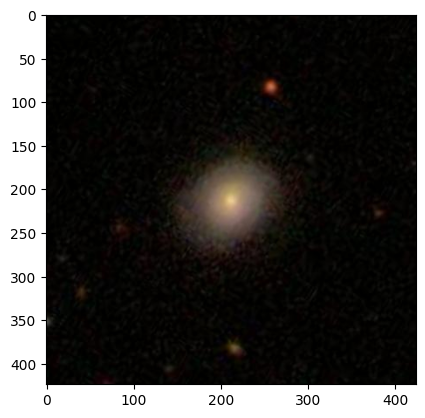

In [28]:
plt.imshow(imread(train_image_1))

Concatenating *categorical_max* to our initial data , (we need the GalaxyID column to map images from the training file to the provided training solution file)

In [29]:
new_file = pd.concat([data,categorical_max],axis=1)

In [30]:
new_file.columns

Index(['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6', 'categorical_max'],
      dtype='object')

In [31]:
galaxy_and_category = new_file[['GalaxyID','categorical_max']]

In [32]:
galaxy_and_category.head()

,GalaxyID,categorical_max
0,100008,Class6.2
1,100023,Class6.2
2,100053,Class6.2
3,100078,Class1.1
4,100090,Class6.2


In [33]:
galaxy_and_category[galaxy_and_category['categorical_max'] =='Class1.1'].iloc[0,0]

100078

The above corresponds to the first ID in the DataFrame , i.e '100078'

In [34]:
np.unique(categorical_max)

array(['Class1.1', 'Class1.2', 'Class1.3', 'Class6.1', 'Class6.2'],
      dtype=object)

The code block below grabs the first GalaxyID encountered for each of the classes in *categorical_max* for a random row so we can visualize what the classes in *categorical_max* looks like from our dataset.

In [35]:
id_list = []
for i in np.unique(categorical_max):
    id_list.append(str(galaxy_and_category[galaxy_and_category['categorical_max'] ==i].iloc[9,0]))

In [36]:
id_list

['101502', '100801', '858943', '101597', '100237']

In [37]:
os.listdir(train_image_path)

['100008.jpg',
 '100023.jpg',
 '100053.jpg',
 '100078.jpg',
 '100090.jpg',
 '100122.jpg',
 '100123.jpg',
 '100128.jpg',
 '100134.jpg',
 '100143.jpg',
 '100150.jpg',
 '100157.jpg',
 '100187.jpg',
 '100204.jpg',
 '100237.jpg',
 '100259.jpg',
 '100263.jpg',
 '100288.jpg',
 '100295.jpg',
 '100322.jpg',
 '100335.jpg',
 '100367.jpg',
 '100380.jpg',
 '100382.jpg',
 '100383.jpg',
 '100402.jpg',
 '100428.jpg',
 '100434.jpg',
 '100444.jpg',
 '100445.jpg',
 '100458.jpg',
 '100474.jpg',
 '100479.jpg',
 '100506.jpg',
 '100513.jpg',
 '100520.jpg',
 '100541.jpg',
 '100561.jpg',
 '100571.jpg',
 '100601.jpg',
 '100623.jpg',
 '100672.jpg',
 '100673.jpg',
 '100724.jpg',
 '100727.jpg',
 '100730.jpg',
 '100740.jpg',
 '100744.jpg',
 '100765.jpg',
 '100774.jpg',
 '100801.jpg',
 '100813.jpg',
 '100821.jpg',
 '100822.jpg',
 '100836.jpg',
 '100852.jpg',
 '100859.jpg',
 '100861.jpg',
 '100867.jpg',
 '100887.jpg',
 '100894.jpg',
 '100938.jpg',
 '100951.jpg',
 '100986.jpg',
 '101007.jpg',
 '101061.jpg',
 '101074.j

Now we create the full path for the GalaxyIDs in *id_list*

In [38]:
sampled_images = [train_image_path+"/"+i+".jpg" for i in id_list ]

In [39]:
sampled_images

['../images_training_rev1//images_training_rev1/101502.jpg',
 '../images_training_rev1//images_training_rev1/100801.jpg',
 '../images_training_rev1//images_training_rev1/858943.jpg',
 '../images_training_rev1//images_training_rev1/101597.jpg',
 '../images_training_rev1//images_training_rev1/100237.jpg']

*vectorized_images* would hold the array for the images converted by *imread()*

In [40]:
vectorized_images = []

In [41]:
for i in sampled_images:
    vectorized_images.append(imread(i))

visualizing what each classes in categorical_max looks like:

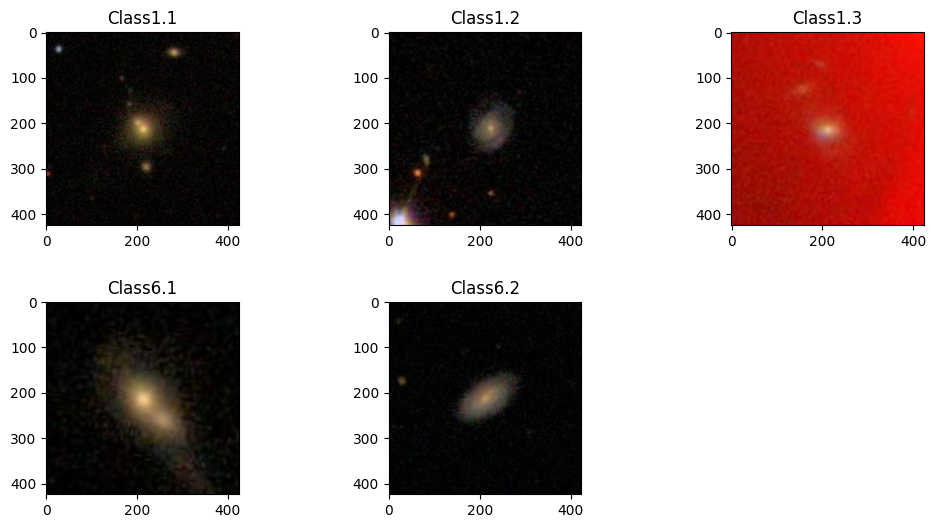

In [42]:
plt.figure(figsize=(12,6))

for i in range(len(np.unique(categorical_max))):
    ax = plt.subplot(2,3,i+1, title=np.unique(categorical_max)[i])
    pic = vectorized_images[list(np.unique(categorical_max)).index(np.unique(categorical_max)[i])]
    ax.imshow(pic)
    
    plt.subplots_adjust(wspace=0.4, hspace= 0.4) 

 Class1.3 after many taking different row values appears to be a category for vague images not neccessarily related to the classes of galaxies we hope to classify. 

So, from the above analysis we are looking at **4** possible classes of galaxies in this dataset.

let's run a simple Kmeans clustering and see how many clusters using the **elbow method** that can be observed:

In [44]:
file = file.fillna(0) #To fill missing values 

In [45]:
wcss = {}
 
for k in range(2,10+1):
    model = KMeans(n_clusters=k)
    model.fit(file)
    wcss[k] = model.inertia_

We then try to locate the optimal k value using the **elbow method**:

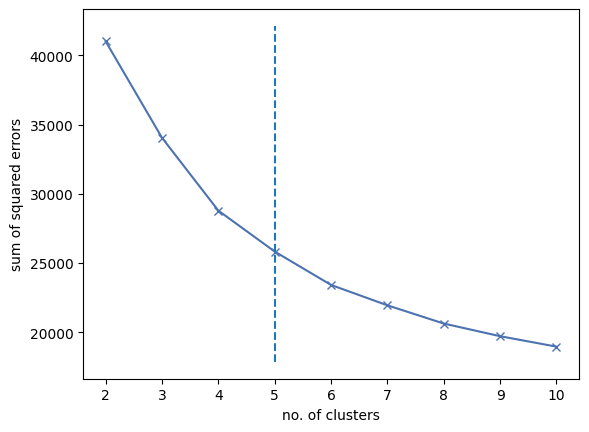

In [46]:
kn = KneeLocator([i for i in wcss.keys()],[i for i in wcss.values()], curve='convex', direction='decreasing')
plt.xlabel('no. of clusters')
plt.ylabel('sum of squared errors')
plt.plot([i for i in wcss.keys()],[i for i in wcss.values()], 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

So we are looking at 5 possible clusters in this dataset which is likely related to the 5 classes we identified earlier, let's test that assumption:

In [57]:
from sklearn.metrics.cluster import homogeneity_score,completeness_score, v_measure_score

In [48]:
categorical_max

0        Class6.2
1        Class6.2
2        Class6.2
3        Class1.1
4        Class6.2
           ...   
61573    Class6.2
61574    Class1.1
61575    Class6.1
61576    Class1.2
61577    Class1.1
Name: categorical_max, Length: 61578, dtype: object

Instantiating with cluster value of **5** and fitting 

In [52]:
model = KMeans(n_clusters=5)
model.fit(file)

KMeans(n_clusters=5)

Now , I'd label encode *categorical_max* so we can compare with the cluster labels:

In [54]:
from sklearn.preprocessing import LabelEncoder

In [56]:
assumed_labels = LabelEncoder().fit_transform(categorical_max)
kmeans_labels = model.labels_

#### Moment of truth:

In [58]:
print(f'Homogeneity : {homogeneity_score(assumed_labels,kmeans_labels)}')

Homogeneity : 0.4809189883845738


In [61]:
print(f'completeness score : {completeness_score(assumed_labels,kmeans_labels)}')

completeness score : 0.3274798401872361


In [62]:
print(f'v measure : {v_measure_score(assumed_labels, kmeans_labels)}')

v measure : 0.3896375598104855


from the completeness score it can be seen using our hypothesis, not all data points that are members of a given class are the same elements of the same cluster , hence the completeness score of approx. **0.33**

## Conclusion:

In light of the analysis carried above ,using the approach of the morphology with the highest value per data point as the defining feature to label that galaxy or data point does not yield a confident criterion for classifying galaxies in this dataset and as such this dataset cannnot be used off the bat for an image classification task (by the above hypothesis).